## This lab is in part adapted from TeachOpenCADD
(https://noteable-beta.edina.ac.uk/user/wmk69tm57bfauozjthxzn1/tree/teachopencadd.git/teachopencadd/talktorials)

In [1]:
# We will load some libraries again first

from pathlib import Path
from warnings import filterwarnings
import time

import pandas as pd
import numpy as np
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

#from teachopencadd.utils import seed_everything

# Silence some expected warnings
filterwarnings("ignore")
# Fix seed for reproducible results
SEED = 22
#seed_everything(SEED)

In this section, we will look into cheminformatics. We ended the last session looking at the interaction of the ligand in the binding site. To refresh our minds, 

1. lets have another look at the protein-ligand interactions with PLIP:

 https://plip-tool.biotec.tu-dresden.de/plip-web/plip/index
 
 What also is informative is to do a short literature study.

Images of interactions 1h1q and 2A6: 

![2a6_a](assets/2a6_a.png)
![2a6_c](assets/2a6_b.png)


*Note: A more detailed view of interactions is included in notebook 01: Bioinformatics*

2. Find the Structure – Activity – Relationship (SAR) for your ligand. Use medicinal chemistry journals, like (but not limited to) J. Med. Chem., Bioorg Med Chem (Lett), ChemMedChem


*Answer:* CDK1 and CDK2 upregulation and activation is associated with deregulation of the the cell cycle. This upregulation is one of the hallmarks of cancer. NU6094, the co-crystalyzed ligand, is an inhibitor for the CSK2/CyclinA complex. Inhibitors for this complex are ATP-competitive inhibitors and inhibition causes the cell cycle to go in arrest. Subsequent apoptosis causes tumors to reduce in size. <sup>1</sup>

*1.	Coxon, C. R. et al. Cyclin-Dependent Kinase (CDK) Inhibitors: Structure–Activity Relationships and Insights into the CDK-2 Selectivity of 6-Substituted 2-Arylaminopurines. J. Med. Chem. 60, 1746–1767 (2017).*

3. First, let's create a new working directory in your jupyter environment.

In [2]:

import os
from pathlib import Path
# We need to check whether the directory is there
try:
    os.mkdir('.cheminformatics')
except:
    print("Directory already exists")
os.chdir('.cheminformatics')

Directory already exists


For this next part, we need to have the SMILES (https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) representation of the molecule. You can retrieve this by going to the pdb, and fetch the InChI key for the ligand in your structure (use the RCSB accession code).

4. The image below shows the InChI key for zma241385 in blue:
![image info](img/LAB01_FIG00.png)

InChI key of 2a6:
![Ligand 2a6](assets/InChI_2a6.png)

5. Using the InChI key, you can retrieve the SMILES from PubChem ((http://pubchem.ncbi.nlm.nih.gov/). Use the search bar where you paste the InChI key in, then run the search, you should retrieve the compound. Click on the entry, and you can find them under 2.1.4 Canonical Smiles. Write down the SMILES that you retrieved from PUBCHEM

- *SMILES:* c1ccc(Nc2nc(OCC3CCCCC3)c3[nH]cnc3n2)cc1
- 2D structure of 2a6:
![structure of 2a6](img/2a6.png)


6.	Find similar compounds by going to the Similarity tab, how many compounds were retrieved? Under settings, you can adjust the tanimoto threshold, change it to 80%, how much are retrieved now?

- *Using Tanimoto threshold > 90:* 137 compounds
- *Using Tanimoto threshold > 80:* > 1000 compounds

7.	Go to https://www.ebi.ac.uk/chembl/, again use the InChI key from the previous step, click the entry. Write down the CHEMBLID. Next, do a Structure Search (button under the compound drawing).



8.	Fetch 95% similar compounds, how much compounds were retrieved? Do the same but with 90%. Do you have more or less compounds than in step 6? Do you know why?

- *Using Tanimoto threshold > 95:* 1 compound (which is the same as the ligand)
- *Using Tanimoto threshold > 90:* 1 compound (which is the same as the ligand) 

There are fewer hits compared to step 6. This difference could be because ChEMBL only searches within its own databases, where as PubChem looks at all publicly available databases, resulting in more hits.


9.	Use the Zinc site to search for possible similar ligands at http://zinc15.docking.org/substances/home/ .Again use the copied smiles string do a 70 % similar search (Tanimoto 70, written as similarity -30). Write down the number of hits and copy 1 representative molecule from each search. Discuss the results, how high is the impact of the similarity threshold?

- For PubChem > 90, CID: 4566 is representative, it visually looks similar to NU6094.
PubChem > 80 has CID: 4578 as representative, as it misses some functional groups, but keeps the same scaffold as NU6094. The similarity threshold seems to affect the found compound by only around 10%. This change does not seem very impactful.

Obtaining and cleaning data.

Let's now start with some data. You should have a CHEMBLID in your list, here we use CHEMBL251 (Adenosine A2a) as an example.

10. We're going to download a dataset downloaded from ChEMBL, and read it into pandas, you can download the files from ChEMBL directly and upload them to the notebook environment (https://www.ebi.ac.uk/chembl/). Be sure to upload the extracted file (not the .zip file) and to give it a clear name so you can write it down in the below code block. 


Ask a TA if anything is unclear!

In [3]:
# .tsv downloaded manually and added to a new data folder in the repo
CHEMBLID = 'CHEMBL2094128' # Enter the CHEMBL ID of your target here
FILENAME = 'CHEMBL2094128.tsv' # The filename of the uploaded file

data = pd.read_csv(f"../.data/{FILENAME}", sep='\t')

print("There are a total of {} datapoints in this set".format(len(data)))
data.head()

There are a total of 1082 datapoints in this set


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL121941,NaN,0,366.43,0,3.15,34,NC(=O)c1ccc(Nc2nc(OCC3CCCCC3)c3nc[nH]c3n2)cc1,IC50,'=',...,Cyclin-dependent kinase 2/cyclin A,Homo sapiens,PROTEIN COMPLEX,CHEMBL1138832,1,Scientific Literature,J. Med. Chem.,2004,None,NaN
1,CHEMBL139653,NaN,0,473.62,0,4.89,72,O=c1ccc2cnc(Nc3ccc(N4CCC(CCCO)CC4)cc3)nc2n1C1C...,IC50,'=',...,Cyclin-dependent kinase 2/cyclin A,Homo sapiens,PROTEIN COMPLEX,CHEMBL1133535,1,Scientific Literature,J. Med. Chem.,2000,None,NaN
2,CHEMBL68975,NaN,0,225.25,0,1.46,1d,CC(C)CCOc1nc(N)nc(N)c1N=O,IC50,'=',...,Cyclin-dependent kinase 2/cyclin A,Homo sapiens,PROTEIN COMPLEX,CHEMBL1136262,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2003,None,NaN
3,CHEMBL326310,NaN,0,261.71,0,3.19,11,O=C(Nc1cc(C2CC2)[nH]n1)c1cccc(Cl)c1,IC50,'=',...,Cyclin-dependent kinase 2/cyclin A,Homo sapiens,PROTEIN COMPLEX,CHEMBL1148336,1,Scientific Literature,J. Med. Chem.,2004,None,NaN
4,CHEMBL420135,NaN,0,257.29,0,2.55,12,COc1cccc(C(=O)Nc2cc(C3CC3)[nH]n2)c1,IC50,'=',...,Cyclin-dependent kinase 2/cyclin A,Homo sapiens,PROTEIN COMPLEX,CHEMBL1148336,1,Scientific Literature,J. Med. Chem.,2004,None,NaN


You will note that we have a lot of data, and we certainly don't need it all, thus we're going to remove quite some columns.

11. Actually, for now we only need the compound ID, pCHEMBL_value, Assay Type, binding affinity and the smiles:

In [4]:
pd_data = data[['Molecule ChEMBL ID','pChEMBL Value','Smiles','Assay Type', 'Standard Relation','Standard Value']]
pd_data.rename(columns={'pChEMBL Value': 'pChEMBL_value', 'Assay Type':'Assay_Type'}, inplace=True)
pd_data.head()

,Molecule ChEMBL ID,pChEMBL_value,Smiles,Assay_Type,Standard Relation,Standard Value
0,CHEMBL121941,4.19,NC(=O)c1ccc(Nc2nc(OCC3CCCCC3)c3nc[nH]c3n2)cc1,B,'=',64000.0
1,CHEMBL139653,6.68,O=c1ccc2cnc(Nc3ccc(N4CCC(CCCO)CC4)cc3)nc2n1C1C...,B,'=',209.0
2,CHEMBL68975,4.89,CC(C)CCOc1nc(N)nc(N)c1N=O,B,'=',13000.0
3,CHEMBL326310,6.00,O=C(Nc1cc(C2CC2)[nH]n1)c1cccc(Cl)c1,B,'=',1000.0
4,CHEMBL420135,6.22,COc1cccc(C(=O)Nc2cc(C3CC3)[nH]n2)c1,B,'=',600.0


Next, we will add an activity classifier, there is a lot of censored data in the set and these typically are compounds that only bind weakly! We still want to know about those non-binders though.

Let's set our activity threshold at PChEMBL > 6.5 for the actives, if you want to know more details have a look at this paper: https://jcheminf.biomedcentral.com/articles/10.1186/s13321-017-0232-0

12. Here we go!

In [5]:
import numpy as np
# Add column for activity
pd_data["active"] = np.zeros(len(pd_data))

# Mark every molecule as active with an pCHEMBL of >= 6.5, 0 otherwise
pd_data.loc[pd_data[pd_data.pChEMBL_value >= 6.5].index, "active"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(pd_data.active.sum()))
print("Number of inactive compounds:", len(pd_data) - int(pd_data.active.sum()))

Number of active compounds: 521
Number of inactive compounds: 561


Finally, we will drop functional assay readout, this is data that we don't want to consider in our model.

In [6]:
pd_data.drop(pd_data[pd_data.Assay_Type != 'B'].index, inplace=True)

print("We have a total of {} activity points left".format(len(pd_data)))

We have a total of 1082 activity points left


In [7]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

#### Molecule encoding

Now we define a function `smiles_to_fp` to generate fingerprints from SMILES.
For now, we incorporated the choice between the following fingerprints:

* maccs
* morgan2 and morgan3

In [8]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    try:
        mol = Chem.MolFromSmiles(smiles)
        
    except:
        return('NaN')

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [9]:
compound_df = pd_data.copy()

In [10]:
# Add column for fingerprint
compound_df["fp"] = compound_df["Smiles"].apply(smiles_to_fp)
compound_df.drop(compound_df[compound_df.fp == 'NaN'].index, inplace=True)
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,Molecule ChEMBL ID,pChEMBL_value,Smiles,Assay_Type,Standard Relation,Standard Value,active,fp
0,CHEMBL121941,4.19,NC(=O)c1ccc(Nc2nc(OCC3CCCCC3)c3nc[nH]c3n2)cc1,B,'=',64000.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL139653,6.68,O=c1ccc2cnc(Nc3ccc(N4CCC(CCCO)CC4)cc3)nc2n1C1C...,B,'=',209.0,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL68975,4.89,CC(C)CCOc1nc(N)nc(N)c1N=O,B,'=',13000.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Machine Learning (ML)

In the following, we will try several ML approaches to classify our molecules. We will use:

* Random Forest (RF)
* Support Vector Machine (SVM) 
* Artificial Neural Network (ANN) 

Additionally, we will comment on the results.

The goal is to test the ability of the model to predict data which it has never seen before in order to flag problems known as over fitting and to assess the generalization ability of the model.

We start by defining a function `model_training_and_validation` which fits a model on a random train-test split of the data and returns measures such as accuracy, sensitivity, specificity and AUC evaluated on the test set. We also plot the ROC curves using `plot_roc_curves_for_models`.

We then define a function named `crossvalidation` which executes a cross validation procedure and prints the statistics of the results over the folds.

#### Helper functions
Helper function to plot customized ROC curves. Code inspired by [stackoverflow](https://stackoverflow.com/questions/42894871/how-to-plot-multiple-roc-curves-in-one-plot-with-legend-and-auc-scores-in-python).

In [11]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=True):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"results/roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    return fig

Helper function to calculate model performance.

In [12]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

 Helper function to fit a machine learning model on a random train-test split of the data and return the performance measures.

In [13]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

**Preprocessing**: Split the data (will be reused for the other models)

In [14]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.active.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=12)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 865
Test data size: 217


#### Random forest classifier

We start with a random forest classifier, where we first set the parameters.

We train the model on a random train-test split and plot the results.

In [15]:
# Set model parameter for random forest
param = {
    "n_estimators": 500,  # number of trees to grows
    "criterion": "entropy",  # cost function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

In [16]:
# Fit model on single split
performance_measures = model_training_and_validation(model_RF, "RF", splits)

Sensitivity: 0.78
Specificity: 0.69
AUC: 0.82


Directory already exists, continuing


'/home/enzo/ACMDD_assignment/.cheminformatics/results/roc_auc.png'

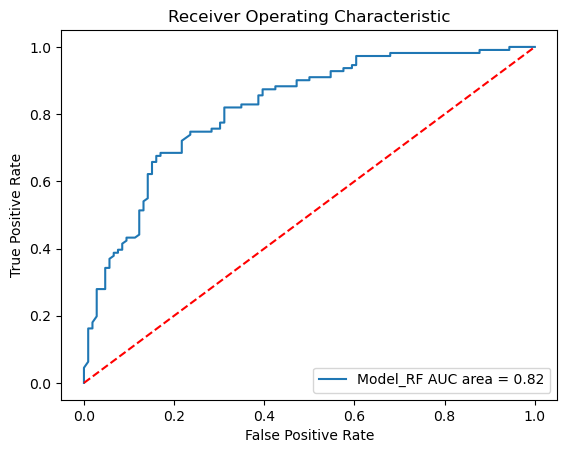

In [17]:
# Initialize the list that stores all models. First one is RF.
models = [{"label": "Model_RF", "model": model_RF}]
try:
    os.mkdir('results')
except:
    print("Directory already exists, continuing")
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y)
result_img = '{}/results/roc_auc.png'.format(os.getcwd())
result_img

#### Support vector classifier
Here we train a SVM with a radial-basis function kernel (also: squared-exponential kernel). 
For more information, see [sklearn RBF kernel](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html).

In [18]:
# Specify model
model_SVM = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)

# Fit model on single split
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

Sensitivity: 0.79
Specificity: 0.76
AUC: 0.82


'/home/enzo/ACMDD_assignment/.cheminformatics/results/roc_auc.png'

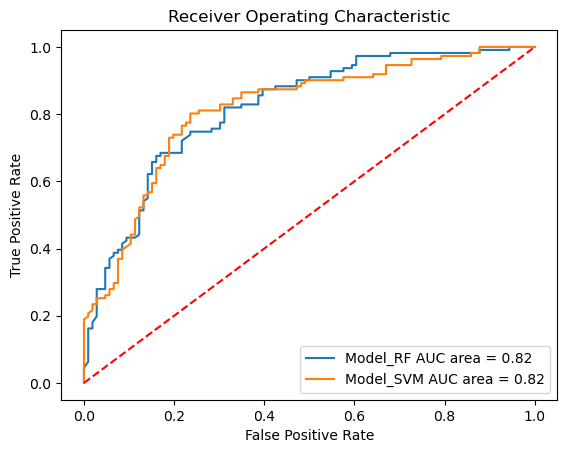

In [19]:
# Append SVM model
models.append({"label": "Model_SVM", "model": model_SVM})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y)
result_img = '{}/results/roc_auc.png'.format(os.getcwd())
result_img

#### Neural network classifier
The last approach we try here is a neural network model. We train an MLPClassifier (Multi-layer Perceptron classifier) with 3 layers, each with 5 neurons. As before, we do the crossvalidation procedure and plot the results. For more information on MLP, see [sklearn MLPClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html).

In [20]:
# Specify model
model_ANN = MLPClassifier(hidden_layer_sizes=(5, 3), random_state=12)

# Fit model on single split
performance_measures = model_training_and_validation(model_ANN, "ANN", splits)

Sensitivity: 0.69
Specificity: 0.74
AUC: 0.76


'/home/enzo/ACMDD_assignment/.cheminformatics/results/roc_auc.png'

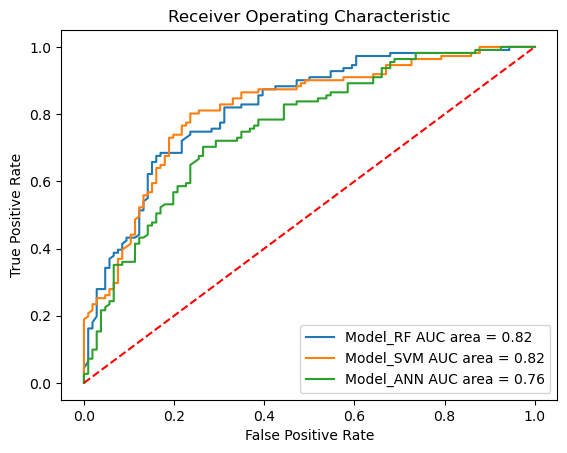

In [21]:
# Append ANN model
models.append({"label": "Model_ANN", "model": model_ANN})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y, True)
result_img = '{}/results/roc_auc.png'.format(os.getcwd())
result_img

Our models show very good values for all measured values (see AUCs) and thus seem to be predictive.

#### Cross-validation

Next, we will perform cross-validation experiments with the three different models.
Therefore, we define a helper function for machine learning model training and validation in a cross-validation loop.

In [22]:
def crossvalidation(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].active.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].active.tolist()

        # Performance for each fold
        accuracy, sens, spec, auc = model_performance(fold_model, test_x, test_y, verbose)

        # Save results
        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    # Print statistics of results
    print(
        f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
        f"and std : {np.std(acc_per_fold):.2f} \n"
        f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
        f"and std : {np.std(sens_per_fold):.2f} \n"
        f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
        f"and std : {np.std(spec_per_fold):.2f} \n"
        f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
        f"and std : {np.std(auc_per_fold):.2f} \n"
        f"Time taken : {time.time() - t0:.2f}s\n"
    )

    return acc_per_fold, sens_per_fold, spec_per_fold, auc_per_fold

**Cross-validation**

We now apply cross-validation and show the statistics for all three ML models. In real world conditions, cross-validation usually applies 5 or more folds, but for the sake of performance we will reduce it to 3. You can change the value of `N_FOLDS` in this cell below.

In [23]:
# We changed to 5 because we have the computing power for it
N_FOLDS = 5

_Note_: Next cell takes long to execute

In [24]:
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.76 	and std : 0.03 
Mean sensitivity: 0.75 	and std : 0.03 
Mean specificity: 0.77 	and std : 0.05 
Mean AUC: 0.83 	and std : 0.03 
Time taken : 4.92s


Model_SVM
Mean accuracy: 0.77 	and std : 0.04 
Mean sensitivity: 0.75 	and std : 0.06 
Mean specificity: 0.79 	and std : 0.04 
Mean AUC: 0.83 	and std : 0.03 
Time taken : 2.01s


Model_ANN
Mean accuracy: 0.71 	and std : 0.02 
Mean sensitivity: 0.69 	and std : 0.05 
Mean specificity: 0.73 	and std : 0.03 
Mean AUC: 0.78 	and std : 0.03 
Time taken : 1.76s



We look at the cross-validation performance for molecules encoded using Morgan fingerprint and not MACCS keys.

In [25]:
# Reset data frame
compound_df = compound_df.drop(['fp'], axis=1)

In [26]:
# Use Morgan fingerprint with radius 3
compound_df["fp"] = compound_df["Smiles"].apply(smiles_to_fp, args=("morgan3",))
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,Molecule ChEMBL ID,pChEMBL_value,Smiles,Assay_Type,Standard Relation,Standard Value,active,fp
0,CHEMBL121941,4.19,NC(=O)c1ccc(Nc2nc(OCC3CCCCC3)c3nc[nH]c3n2)cc1,B,'=',64000.0,0.0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL139653,6.68,O=c1ccc2cnc(Nc3ccc(N4CCC(CCCO)CC4)cc3)nc2n1C1C...,B,'=',209.0,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL68975,4.89,CC(C)CCOc1nc(N)nc(N)c1N=O,B,'=',13000.0,0.0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."


_Note_: Next cell takes long to execute

In [27]:
for model in models:
    if model["label"] == "Model_SVM":
        # SVM is super slow with long fingerprints
        # and will have a performance similar to RF
        # We can skip it in this test, but if you want
        # to run it, feel free to replace `continue` with `pass`
        continue
    print("\n=======")
    print(model["label"])
    reduced_df = compound_df[['active','fp']]
    crossvalidation(model["model"], reduced_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.80 	and std : 0.04 
Mean sensitivity: 0.79 	and std : 0.04 
Mean specificity: 0.81 	and std : 0.04 
Mean AUC: 0.88 	and std : 0.03 
Time taken : 14.90s


Model_ANN
Mean accuracy: 0.79 	and std : 0.02 
Mean sensitivity: 0.78 	and std : 0.04 
Mean specificity: 0.80 	and std : 0.04 
Mean AUC: 0.86 	and std : 0.03 
Time taken : 120.48s



So far, we have been running classification models (is the compound going to be active or not, indicated by the active column we added in the dataframe). The next step is to see if we can also train a classification model. We will remove the censored data (the ones with no pChEMBL value), and train another model. 

Make a new function that works with regression:

In [28]:
def crossvalidation_reg(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    MAE_per_fold = []
    RMSE_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].pChEMBL_value.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].pChEMBL_value.tolist()
        
        test_results = fold_model.predict(test_x)
        # Prediction probability on test set
        from sklearn import metrics

        MAE_per_fold.append(metrics.mean_absolute_error(test_y, test_results))
        #print('Mean Squared Error (MSE):', metrics.mean_squared_error(test_y, test_results))
        RMSE_per_fold.append(np.sqrt(metrics.mean_squared_error(test_y, test_results)))
        #mape = np.mean(np.abs((gt - pred) / np.abs(gt)))
        #print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
        #print('Accuracy:', round(100*(1 - mape), 2))
    return(MAE_per_fold,RMSE_per_fold,fold_model)

Next, make new data and run.

In [29]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.pChEMBL_value.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=12)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 865
Test data size: 217


In [30]:
# Kick out NaN in the pChEMBL values
compound_df_noNaN = compound_df.dropna()

# Append RF Regressor model
#models.append({"label": "Model_RF_reg", "model": RandomForestRegressor})
#Train model with RandomForestRegressor
regressor = RandomForestRegressor()
MAE, RMSE,trained_model = crossvalidation_reg(regressor , compound_df_noNaN, n_folds=N_FOLDS)

print(
f"MAE: {np.mean(MAE):.2f} \t"
f"and std : {np.std(MAE):.2f} \n"
f"RMSE: {np.mean(RMSE):.2f} \t"
f"and std : {np.std(RMSE):.2f} \n"
)


MAE: 0.53 	and std : 0.02 
RMSE: 0.72 	and std : 0.02 



You will notice that we report different measures of accuracy. We no longer deal with categorical data so we now look at the errors between experimental data and predicted data using the MAE and RMSE. Typically, an MAE/RMSE below 0.6, approximately, is considered quite decent/

Next, let's use the RF model to run predictions on a new compound. You can design your compounds in a sketcher (chemdraw (https://chemdrawdirect.perkinelmer.cloud/js/sample/index.html#) or an online tool).

In [37]:
# The first entry is the co-crystalized ligand 
# which is added for reference (so we can compare 
# to its actual pChEMBL value)
# BELOW: add your own molecules
test_smiles = [
    'c1ccc(Nc2nc(OCC3CCCCC3)c3[nH]cnc3n2)cc1', #2A6
    # Our own ligand, only scores marginally better than the ligand in ML
    'O=C(O)c4nc3nc(Nc1ccccc1)nc(OCC2CCCCC2)c3[nH]4',
]


fps = []

for smiles in test_smiles: 
    fp = smiles_to_fp(smiles,'morgan3')
    fps.append(fp)

predictions = trained_model.predict(fps)
print("SMILES, PREDICTION")
for i, prediction in enumerate(predictions):
    print('{},{:.2f}'.format(test_smiles[i], prediction))

SMILES, PREDICTION
c1ccc(Nc2nc(OCC3CCCCC3)c3[nH]cnc3n2)cc1,5.94
O=C(O)c4cccc(Nc3nc(OCC1CCCCC1)c2[nH]cnc2n3)c4,6.11
O=C(O)c4cccc(Nc3nc(OCC1CCCCC1)c2nc[nH]c2n3)c4,5.44
CS(=O)(=O)Nc4cccc(Nc3nc(OCC1CCCCC1)c2[nH]cnc2n3)c4,6.13
COC(=O)c4cccc(Nc3nc(OCC1CCCCC1)c2[nH]cnc2n3)c4,5.52
c4ccc(Nc3nc(OCC1CCCCC1)c2[nH]cnc2n3)cc4,5.94
O=C(O)c4nc3nc(Nc1ccccc1)nc(OCC2CCCCC2)c3[nH]4,6.00
CC(=O)Oc4nc3nc(Nc1ccccc1)nc(OCC2CCCCC2)c3[nH]4,6.05


The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


You can paste a smiles string of a designed molecule in here yourself. It's probably a good idea to start close to molecules that are already in the training set (check ChEMBL for inspiration). Of course you can also go crazy and design what you like, but bear in mind that Machine Learning has that pesky applicability domain so the results you obtain might not be that accurate.

You can generate SMILES strings for instance using the drawing function in molview (https://molview.org/). 

## Discussion

* Which model performed best on our data set and why?
    * All three models perform (very) well on our dataset. The best models are the random forest and support vector machine models which showed a mean AUC of about 90%. Our neural network showed slightly lower results. 
    * There might be several reasons that random forest and support vector machine models performed best. Our dataset might be easily separable in active/inactive with some simple tree-like decisions or with the radial basis function, respectively. Thus, there is not such a complex pattern in the fingerprints to do this classification.
    * A cause for the slightly poorer performance of the ANN could be that there was simply too few data to train the model on.
    * Additionally, it is always advisable to have another external validation set for model evaluation.  
* Was MACCS the right choice?
    * Obviously, MACCS was good to start training and validating models to see if a classification is possible. 
    * However, MACCS keys are rather short (166 bit) compared to others (2048 bit), as for example Morgan fingerprint. As shown in the last simulation, having longer fingerprint helps the learning process. All tested models performed slightly better using Morgan fingerprints (see mean AUC increase).

    
### Where can we go from here?

* We successfully trained several models. 
* The next step could be to use these models to do a classification with an unknown screening dataset to predict novel potential EGFR inhibitors.
* An example for a large screening data set is e.g. [MolPort](https://www.molport.com/shop/database-download) with over 7 million compounds.
* Our models could be used to rank the MolPort compounds and then further study those with the highest predicted probability of being active.
* For such an application, see also the [TDT Tutorial](https://github.com/sriniker/TDT-tutorial-2014) developed by S. Riniker and G. Landrum, where they trained a fusion model to screen [eMolecules](https://www.emolecules.com/) for new anti-malaria drugs.

## Model performance compared to real world

* We saw that the model predicts values lower than that the docking scores showed. The score for 2a6 is 6.9 according to Autodock Vina, while the model predicted a score of 5.94.
* Our own designed ligand had a score of 6.00 which was higher than the 5.94 of 2a6. We saw this as an improvement and docked the ligand. This resulted in a docking pChEMBL score of 7.44 for our own ligand, which is a huge improvement.

We started out from ligand that was crystallised along with our protein, 2a6. We entered the smile of 2a6 in our machine learning program and discovered an estimated pIC50 of around 6.05. We followed up by referencing ChEMBL where we looked at molecules that contained the same scaffold as 2a6 but had a lower pIC50. Here we looked at which groups they had in common but were not present in 2a6. This did not result in molecules with a higher estimated pIC50. Upon visualising the protein structure with the original co-crystallised ligand, we noticed hydrophobic bonds on the cyclohexylmethoxy group on 2a6 with the protein. Our hypothesis was that increasing the amount of hydrogen bonds that could be formed by our new ligand would increase its docking score. Therefore, we introduced a carboxylic acid to increase the amount of hydrogen bonds that can be formed. Creating the new ligand Jhilly. 

![jhilly](img/Jhilly.png)